## Objective: Sentiment Classification Reviews categorized into positive, negative, or neutral sentiments, evaluated using accuracy

Previously, we have compared three models for sentiment classidication on a subset of the raw dataset: Logistic Regression, LSTM models and DistilBERT. Consider best performce for malti-class analysis and save time, we will use LSTM model on the whole dataset.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [5]:
# Load dataset
file_path = "Final Project/Amazon_review.csv"
df = pd.read_csv(file_path)

# Display basic information
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18447 entries, 0 to 18446
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      18447 non-null  int64 
 1   ProductId               18447 non-null  object
 2   UserId                  18447 non-null  object
 3   ProfileName             18446 non-null  object
 4   HelpfulnessNumerator    18447 non-null  int64 
 5   HelpfulnessDenominator  18447 non-null  int64 
 6   Score                   18447 non-null  int64 
 7   Time                    18447 non-null  int64 
 8   Summary                 18447 non-null  object
 9   Text                    18447 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.4+ MB
None
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2 

In [7]:
# Remove rows with any missing values
df = df.dropna()

In [9]:
# Check for missing values
print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 18446 entries, 0 to 18446
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      18446 non-null  int64 
 1   ProductId               18446 non-null  object
 2   UserId                  18446 non-null  object
 3   ProfileName             18446 non-null  object
 4   HelpfulnessNumerator    18446 non-null  int64 
 5   HelpfulnessDenominator  18446 non-null  int64 
 6   Score                   18446 non-null  int64 
 7   Time                    18446 non-null  int64 
 8   Summary                 18446 non-null  object
 9   Text                    18446 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.5+ MB
None
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  

In [11]:
# Define a function to clean text data
def clean_text(text):
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove HTML tags/headers
    text = re.sub(r'<[^>]+>', ' ', text)
    # 3. Remove non-alphabetic characters (keeping letters and whitespace)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 4. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [17]:
# Clean the 'Text' column using the defined function
df['Text'] = df['Text'].apply(clean_text)

In [19]:
# Convert Score into Sentiment Labels
def label_sentiment(score):
    if score >= 4:
        return 2  # Positive
    elif score == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df["Sentiment"] = df["Score"].apply(label_sentiment)

In [21]:
#Significant imbalance here, we need to compute the Class Weights
# Define features and target
X = df['Text']      
y = df['Sentiment'] 

# Split data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Initialize and fit the tokenizer on training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [25]:
# Build LSTM model
classes = np.unique(y_train)
num_classes = len(classes)
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history = lstm_model.fit(
    X_train_pad, np.array(y_train),
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/5
415/415 - 10s - 23ms/step - accuracy: 0.7703 - loss: 0.7004 - val_accuracy: 0.7751 - val_loss: 0.6571
Epoch 2/5
415/415 - 9s - 21ms/step - accuracy: 0.7801 - loss: 0.6534 - val_accuracy: 0.7900 - val_loss: 0.6057
Epoch 3/5
415/415 - 9s - 21ms/step - accuracy: 0.7966 - loss: 0.6135 - val_accuracy: 0.7954 - val_loss: 0.6113
Epoch 4/5
415/415 - 9s - 22ms/step - accuracy: 0.7944 - loss: 0.5693 - val_accuracy: 0.7879 - val_loss: 0.6092
Epoch 5/5
415/415 - 9s - 22ms/step - accuracy: 0.7888 - loss: 0.5634 - val_accuracy: 0.7927 - val_loss: 0.5670


f1-score and recall vlues are low in 0 and 1, we wondering if the dataset is imblanced

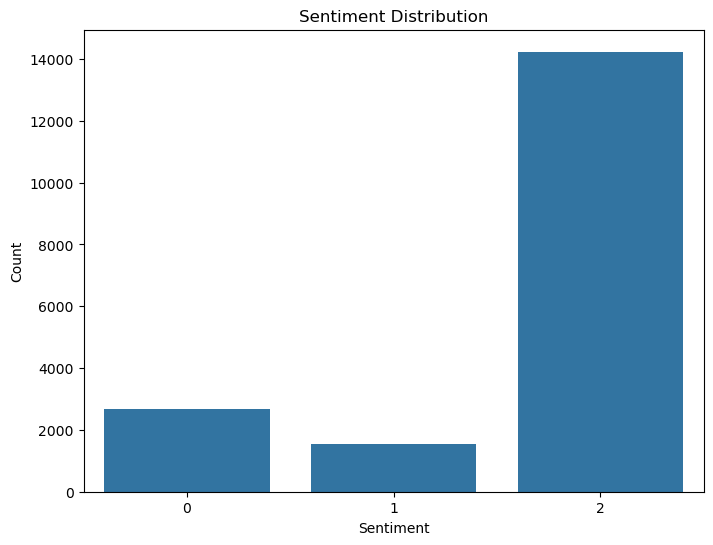

In [31]:
# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [33]:
# Compute class weights based on the original training set (to help address imbalance)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("\nComputed class weights:")
print(class_weight_dict)


Computed class weights:
{0: 2.301669006395258, 1: 3.989186266558529, 2: 0.431992505416008}


In [35]:
# Train the model
history = lstm_model.fit(
    X_train_pad, np.array(y_train),
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    verbose=2
)

Epoch 1/5
415/415 - 9s - 22ms/step - accuracy: 0.6940 - loss: 0.9407 - val_accuracy: 0.4031 - val_loss: 1.0270
Epoch 2/5
415/415 - 9s - 21ms/step - accuracy: 0.7387 - loss: 0.8895 - val_accuracy: 0.7446 - val_loss: 0.8504
Epoch 3/5
415/415 - 9s - 21ms/step - accuracy: 0.6903 - loss: 0.8722 - val_accuracy: 0.7940 - val_loss: 0.8893
Epoch 4/5
415/415 - 9s - 21ms/step - accuracy: 0.7733 - loss: 0.7578 - val_accuracy: 0.7737 - val_loss: 0.7437
Epoch 5/5
415/415 - 9s - 21ms/step - accuracy: 0.8275 - loss: 0.7231 - val_accuracy: 0.7561 - val_loss: 0.8604


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

--- LSTM Model Evaluation (Multi-Class) ---
Accuracy: 0.7385
Weighted F1 Score: 0.7575

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.55      0.52       534
           1       0.16      0.26      0.20       308
           2       0.90      0.83      0.86      2848

    accuracy                           0.74      3690
   macro avg       0.52      0.54      0.53      3690
weighted avg       0.78      0.74      0.76      3690



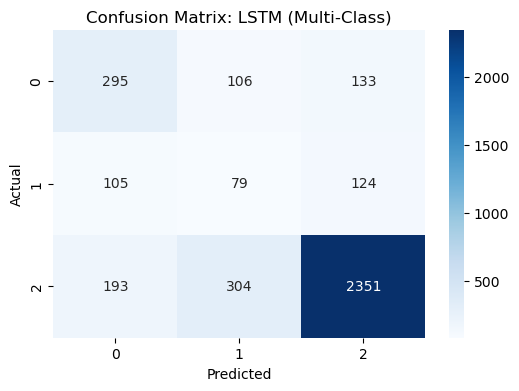

In [37]:
#Evaluate the LSTM Model
# Predict probabilities on the test set and convert to predicted class indices
y_pred_probs = lstm_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("\n--- LSTM Model Evaluation (Multi-Class) ---")
print("Accuracy: {:.4f}".format(accuracy))
print("Weighted F1 Score: {:.4f}".format(weighted_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: LSTM (Multi-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [47]:
# Build a stacked LSTM model with two LSTM layers
lstm_stacked_model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=True),  
    Dropout(0.5),
    LSTM(64),                         
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

lstm_stacked_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_stacked_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
history2 = lstm_stacked_model.fit(
    X_train_pad, np.array(y_train),
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    verbose=2
)

Epoch 1/5
415/415 - 18s - 43ms/step - accuracy: 0.4178 - loss: 1.1011 - val_accuracy: 0.1308 - val_loss: 1.1031
Epoch 2/5
415/415 - 17s - 42ms/step - accuracy: 0.5382 - loss: 1.0735 - val_accuracy: 0.2785 - val_loss: 1.0900
Epoch 3/5
415/415 - 17s - 42ms/step - accuracy: 0.5713 - loss: 1.0073 - val_accuracy: 0.7114 - val_loss: 1.0628
Epoch 4/5
415/415 - 18s - 43ms/step - accuracy: 0.5587 - loss: 0.9248 - val_accuracy: 0.7195 - val_loss: 1.0468
Epoch 5/5
415/415 - 17s - 42ms/step - accuracy: 0.6581 - loss: 0.8478 - val_accuracy: 0.6701 - val_loss: 1.0687


116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

--- LSTM Model Evaluation (Multi-Class) ---
Accuracy: 0.6550
Weighted F1 Score: 0.6868

Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.65      0.41       534
           1       0.17      0.16      0.17       308
           2       0.90      0.71      0.80      2848

    accuracy                           0.66      3690
   macro avg       0.46      0.51      0.46      3690
weighted avg       0.76      0.66      0.69      3690



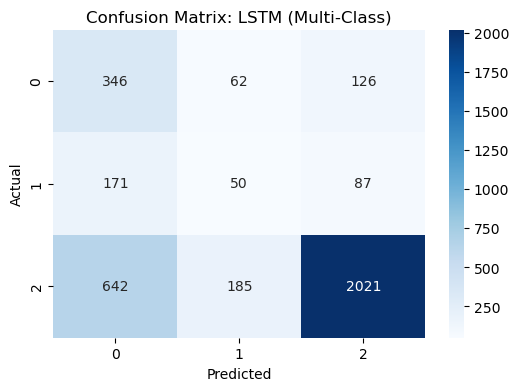

In [51]:
#Evaluate the stacked LSTM Model
# Predict probabilities on the test set and convert to predicted class indices
y_pred_probs = lstm_stacked_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("\n--- LSTM Model Evaluation (Multi-Class) ---")
print("Accuracy: {:.4f}".format(accuracy))
print("Weighted F1 Score: {:.4f}".format(weighted_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: LSTM (Multi-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
# Hyperparameter grid
lstm_units_list = [32, 64, 128]
dropout_rates = [0.2, 0.3, 0.5]
stacked_options = [False, True]

best_val_acc = 0
best_config = None

for units in lstm_units_list:
    for dropout in dropout_rates:
        for stacked in stacked_options:
            print(f"Training model with LSTM units: {units}, Dropout: {dropout}, Stacked: {stacked}")
            model = Sequential()
            model.add(Embedding(input_dim=10000, output_dim=64))
            # First LSTM layer with return_sequences if stacking is desired
            model.add(LSTM(units, return_sequences=stacked))
            model.add(Dropout(dropout))
            # Optional second LSTM layer
            if stacked:
                model.add(LSTM(units))
                model.add(Dropout(dropout))
            model.add(Dense(len(np.unique(y_train)), activation='softmax'))
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
            history = model.fit(X_train_pad, np.array(y_train),
                                epochs=5,
                                batch_size=32,
                                validation_split=0.1,
                                class_weight=class_weight_dict,
                                verbose=0)
            val_acc = history.history['val_accuracy'][-1]
            print(f"Validation Accuracy: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_config = (units, dropout, stacked)

print("\nBest configuration:")
print(f"LSTM Units: {best_config[0]}, Dropout: {best_config[1]}, Stacked: {best_config[2]}, Val Accuracy: {best_val_acc:.4f}")

Training model with LSTM units: 32, Dropout: 0.2, Stacked: False
Validation Accuracy: 0.6829
Training model with LSTM units: 32, Dropout: 0.2, Stacked: True
Validation Accuracy: 0.1992
Training model with LSTM units: 32, Dropout: 0.3, Stacked: False
Validation Accuracy: 0.7622
Training model with LSTM units: 32, Dropout: 0.3, Stacked: True
Validation Accuracy: 0.6795
Training model with LSTM units: 32, Dropout: 0.5, Stacked: False
Validation Accuracy: 0.7215
Training model with LSTM units: 32, Dropout: 0.5, Stacked: True
Validation Accuracy: 0.7256
Training model with LSTM units: 64, Dropout: 0.2, Stacked: False
Validation Accuracy: 0.6755
Training model with LSTM units: 64, Dropout: 0.2, Stacked: True
Validation Accuracy: 0.7344
Training model with LSTM units: 64, Dropout: 0.3, Stacked: False
Validation Accuracy: 0.5874
Training model with LSTM units: 64, Dropout: 0.3, Stacked: True
Validation Accuracy: 0.7466
Training model with LSTM units: 64, Dropout: 0.5, Stacked: False
Validation

In [57]:
# Build a stacked LSTM model with best configuration
lstm_best_model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(128, return_sequences=True),  
    Dropout(0.3),
    LSTM(128),                         
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  
])

lstm_best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_best_model.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history3 = lstm_best_model.fit(
    X_train_pad, np.array(y_train),
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    verbose=2
)

Epoch 1/20
415/415 - 55s - 131ms/step - accuracy: 0.3899 - loss: 1.1011 - val_accuracy: 0.6125 - val_loss: 1.0811
Epoch 2/20
415/415 - 53s - 128ms/step - accuracy: 0.5504 - loss: 1.0738 - val_accuracy: 0.6179 - val_loss: 1.2197
Epoch 3/20
415/415 - 53s - 128ms/step - accuracy: 0.5334 - loss: 0.9802 - val_accuracy: 0.2310 - val_loss: 1.1430
Epoch 4/20
415/415 - 52s - 124ms/step - accuracy: 0.6218 - loss: 0.8730 - val_accuracy: 0.7846 - val_loss: 0.8705
Epoch 5/20
415/415 - 50s - 121ms/step - accuracy: 0.7143 - loss: 0.7779 - val_accuracy: 0.6721 - val_loss: 0.9270
Epoch 6/20
415/415 - 52s - 124ms/step - accuracy: 0.7979 - loss: 0.6523 - val_accuracy: 0.7459 - val_loss: 0.7707
Epoch 7/20
415/415 - 53s - 127ms/step - accuracy: 0.8262 - loss: 0.5604 - val_accuracy: 0.7507 - val_loss: 0.7732
Epoch 8/20
415/415 - 52s - 124ms/step - accuracy: 0.8553 - loss: 0.4881 - val_accuracy: 0.7832 - val_loss: 0.6871
Epoch 9/20
415/415 - 52s - 126ms/step - accuracy: 0.8813 - loss: 0.4071 - val_accuracy: 

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

--- LSTM Model Evaluation (Multi-Class) ---
Accuracy: 0.7743
Weighted F1 Score: 0.7784

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55       534
           1       0.22      0.27      0.24       308
           2       0.88      0.88      0.88      2848

    accuracy                           0.77      3690
   macro avg       0.56      0.56      0.56      3690
weighted avg       0.78      0.77      0.78      3690



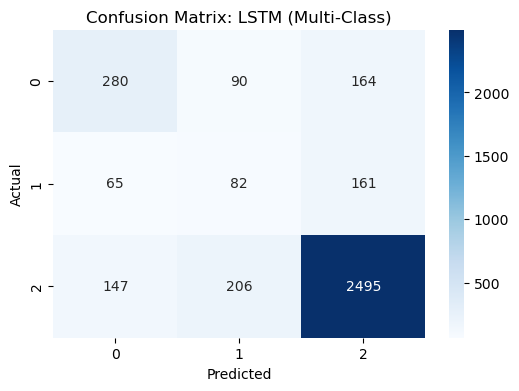

In [61]:
#Evaluate the stacked LSTM Model
# Predict probabilities on the test set and convert to predicted class indices
y_pred_probs = lstm_best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("\n--- LSTM Model Evaluation (Multi-Class) ---")
print("Accuracy: {:.4f}".format(accuracy))
print("Weighted F1 Score: {:.4f}".format(weighted_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: LSTM (Multi-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [63]:
history3 = lstm_best_model.fit(
    X_train_pad, np.array(y_train),
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    verbose=2
)

Epoch 1/5
415/415 - 48s - 117ms/step - accuracy: 0.9855 - loss: 0.0558 - val_accuracy: 0.7514 - val_loss: 1.1678
Epoch 2/5
415/415 - 49s - 118ms/step - accuracy: 0.9831 - loss: 0.0601 - val_accuracy: 0.8015 - val_loss: 1.0470
Epoch 3/5
415/415 - 51s - 123ms/step - accuracy: 0.9812 - loss: 0.0738 - val_accuracy: 0.7656 - val_loss: 1.0878
Epoch 4/5
415/415 - 53s - 127ms/step - accuracy: 0.9880 - loss: 0.0440 - val_accuracy: 0.8062 - val_loss: 0.9673
Epoch 5/5
415/415 - 49s - 118ms/step - accuracy: 0.9888 - loss: 0.0418 - val_accuracy: 0.8062 - val_loss: 1.0789


116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step

--- LSTM Model Evaluation (Multi-Class) ---
Accuracy: 0.7867
Weighted F1 Score: 0.7866

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55       534
           1       0.24      0.28      0.26       308
           2       0.88      0.90      0.89      2848

    accuracy                           0.79      3690
   macro avg       0.58      0.56      0.57      3690
weighted avg       0.79      0.79      0.79      3690



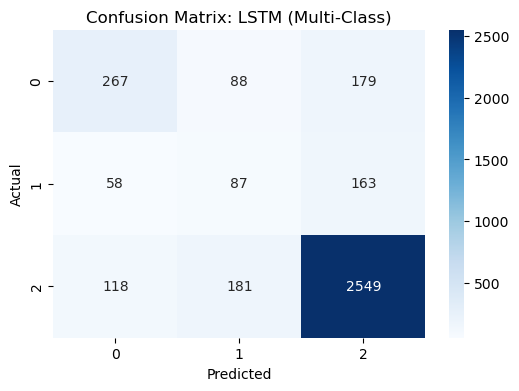

In [65]:
#Evaluate the stacked LSTM Model
# Predict probabilities on the test set and convert to predicted class indices
y_pred_probs = lstm_best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("\n--- LSTM Model Evaluation (Multi-Class) ---")
print("Accuracy: {:.4f}".format(accuracy))
print("Weighted F1 Score: {:.4f}".format(weighted_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: LSTM (Multi-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()